In [137]:
# fastai and date_part function :

from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute._base import SimpleImputer as Imputer
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from sklearn.ensemble import forest
from sklearn.tree import export_graphviz
# importing packages
from sklearn.preprocessing import LabelEncoder, StandardScaler
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from sklearn.ensemble import forest
from sklearn.tree import export_graphviz
from IPython.lib.deepreload import reload as dreload
import PIL, os, numpy as np, math, collections, threading, json, random, scipy, cv2
import pandas as pd, pickle, sys, itertools, string, sys, re, datetime, time, shutil, copy
import seaborn as sns, matplotlib
import IPython,   sklearn, warnings, pdb
import contextlib
from abc import abstractmethod
from glob import glob, iglob
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
from itertools import chain
from functools import partial
from collections import Iterable, Counter, OrderedDict
from IPython.lib.display import FileLink
from PIL import Image, ImageEnhance, ImageOps
from sklearn import metrics, ensemble, preprocessing
from operator import itemgetter, attrgetter
from pathlib import Path
from distutils.version import LooseVersion

from matplotlib import pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from sklearn.ensemble import forest
from sklearn.tree import export_graphviz


def set_plot_sizes(sml, med, big):
    plt.rc('font', size=sml)          # controls default text sizes
    plt.rc('axes', titlesize=sml)     # fontsize of the axes title
    plt.rc('axes', labelsize=med)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=sml)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=sml)    # fontsize of the tick labels
    plt.rc('legend', fontsize=sml)    # legend fontsize
    plt.rc('figure', titlesize=big)  # fontsize of the figure title

def parallel_trees(m, fn, n_jobs=8):
        return list(ProcessPoolExecutor(n_jobs).map(fn, m.estimators_))

def draw_tree(t, df, size=10, ratio=0.6, precision=0):

    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True,
                      special_characters=True, rotate=True, precision=precision)
    IPython.display.display(graphviz.Source(re.sub('Tree {',
       f'Tree {{ size={size}; ratio={ratio}', s)))

def combine_date(years, months=1, days=1, weeks=None, hours=None, minutes=None,
              seconds=None, milliseconds=None, microseconds=None, nanoseconds=None):
    years = np.asarray(years) - 1970
    months = np.asarray(months) - 1
    days = np.asarray(days) - 1
    types = ('<M8[Y]', '<m8[M]', '<m8[D]', '<m8[W]', '<m8[h]',
             '<m8[m]', '<m8[s]', '<m8[ms]', '<m8[us]', '<m8[ns]')
    vals = (years, months, days, weeks, hours, minutes, seconds,
            milliseconds, microseconds, nanoseconds)
    return sum(np.asarray(v, dtype=t) for t, v in zip(types, vals)
               if v is not None)

def get_sample(df,n):

    idxs = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idxs].copy()

def add_datepart(df, fldnames, drop=True, time=False, errors="raise"):	

    if isinstance(fldnames,str): 
        fldnames = [fldnames]
    for fldname in fldnames:
        fld = df[fldname]
        fld_dtype = fld.dtype
        if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
            fld_dtype = np.datetime64

        if not np.issubdtype(fld_dtype, np.datetime64):
            df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True, errors=errors)
        targ_pre = re.sub('[Dd]ate$', '', fldname)
        attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
                'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
        if time: attr = attr + ['Hour', 'Minute', 'Second']
        for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
        df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
        if drop: df.drop(fldname, axis=1, inplace=True)

def is_date(x): return np.issubdtype(x.dtype, np.datetime64)

def train_cats(df):

    for n,c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()

def apply_cats(df, trn):

    for n,c in df.items():
        if (n in trn.columns) and (trn[n].dtype.name=='category'):
            df[n] = c.astype('category').cat.as_ordered()
            df[n].cat.set_categories(trn[n].cat.categories, ordered=True, inplace=True)

def fix_missing(df, col, name, na_dict):
 
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict

def numericalize(df, col, name, max_n_cat):
 
    if not is_numeric_dtype(col) and ( max_n_cat is None or len(col.cat.categories)>max_n_cat):
        df[name] = pd.Categorical(col).codes+1

def scale_vars(df, mapper):
    warnings.filterwarnings('ignore', category=sklearn.exceptions.DataConversionWarning)
    if mapper is None:
        map_f = [([n],StandardScaler()) for n in df.columns if is_numeric_dtype(df[n])]
        mapper = DataFrameMapper(map_f).fit(df)
    df[mapper.transformed_names_] = mapper.transform(df)
    return mapper

def proc_df(df, y_fld=None, skip_flds=None, ignore_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):
 
    if not ignore_flds: ignore_flds=[]
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    else: df = df.copy()
    ignored_flds = df.loc[:, ignore_flds]
    df.drop(ignore_flds, axis=1, inplace=True)
    if preproc_fn: preproc_fn(df)
    if y_fld is None: y = None
    else:
        if not is_numeric_dtype(df[y_fld]): df[y_fld] = pd.Categorical(df[y_fld]).codes
        y = df[y_fld].values
        skip_flds += [y_fld]
    df.drop(skip_flds, axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    else: na_dict = na_dict.copy()
    na_dict_initial = na_dict.copy()
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if len(na_dict_initial.keys()) > 0:
        df.drop([a + '_na' for a in list(set(na_dict.keys()) - set(na_dict_initial.keys()))], axis=1, inplace=True)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    df = pd.get_dummies(df, dummy_na=True)
    df = pd.concat([ignored_flds, df], axis=1)
    res = [df, y, na_dict]
    if do_scale: res = res + [mapper]
    return res

def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

def set_rf_samples(n):
  
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n))

def reset_rf_samples():
  
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n_samples))

def get_nn_mappers(df, cat_vars, contin_vars):
    # Replace nulls with 0 for continuous, "" for categorical.
    for v in contin_vars: df[v] = df[v].fillna(df[v].max()+100,)
    for v in cat_vars: df[v].fillna('#NA#', inplace=True)

    # list of tuples, containing variable and instance of a transformer for that variable
    # for categoricals, use LabelEncoder to map to integers. For continuous, standardize
    cat_maps = [(o, LabelEncoder()) for o in cat_vars]
    contin_maps = [([o], StandardScaler()) for o in contin_vars]


from sklearn.preprocessing import LabelEncoder, StandardScaler
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from sklearn.ensemble import forest
from sklearn.tree import export_graphviz
#%%
def add_datepart(df, fldname, drop=True):
    fld = df[fldname]
    if not np.issubdtype(fld.dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    for n in ('Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start'):
        df[targ_pre+n] = getattr(fld.dt,n.lower())
    df[targ_pre+'Elapsed'] = fld.astype(np.int64) // 10**9
    if drop: df.drop(fldname, axis=1, inplace=True)

import re
re.compile('<title>(.*)</title>')




re.compile(r'<title>(.*)</title>', re.UNICODE)

In [138]:
# some more libaries :

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from datetime import datetime
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import random 
from pandas import DataFrame
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot as plt

rmse for moving average is : 55.90026000649112


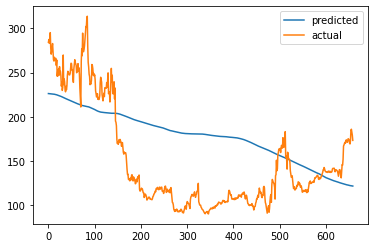

In [133]:
#moving average

d = pd.read_csv('Project_Intro2ML_dataset.csv')
data = d.iloc[:3299]
y = data['Close']
idxtest = []
len  = data.shape[0]
for i in range(len):
    if i < len*0.8:
        idxtest.append(False)
    else:
        idxtest.append(True)
idxtest = np.array(idxtest)
y_test = data[idxtest]
y_train = data[~idxtest]

#X = []
#for i in range(1 , y.shape[0]+1):
#    X.append(i)
M = 512

train = []
for i in range(y_test.shape[0]):
    train.append(y_test['Close'].iloc[i])
    
ma = []
for i in range( y_train.shape[0], len ):
    ma.append(np.mean(y.iloc[i - M : i - 1]))
    

rmse=sqrt(mean_squared_error(train, ma))
print("rmse for moving average is :" , rmse)

plt.plot( ma, label='predicted' )
plt.plot( train,  label='actual')
plt.legend()



In [139]:
#loading the and shuffling the data
from sklearn.utils import shuffle


d = pd.read_csv('Project_Intro2ML_dataset.csv')
data = d.iloc[:3299]
data.head()

data = shuffle(data)

add_datepart(data, 'Date')
data.head()
 

Open    High     Low  ...  Is_year_end  Is_year_start     Elapsed
946   850.3  905.15  827.65  ...        False          False  1425945600
2167  357.0  360.40  353.20  ...        False          False  1271376000
2221  361.0  369.40  352.00  ...        False          False  1264377600
2849  113.0  114.90  111.50  ...        False          False  1183507200
676   508.6  529.80  507.60  ...        False          False  1460419200

[5 rows x 20 columns]

as you can see above I shuffled the data and then used add_datepart to show the properties of the data. and figure out the dates

In [140]:
# Linear Regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

Close = data['Close']
y = Close
X = data['Elapsed']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train= X_train.values.reshape(-1, 1)
y_train= y_train.values.reshape(-1, 1)
X_test = X_test.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)


model = LinearRegression() #create linear regression object
model.fit(X_train, y_train) #train model on train data
a = model.score(X_test, y_test) #check score
print("the score is: " , a)
y_pre = model.predict(X_test)
mse = sklearn.metrics.mean_squared_error(y_pre, y_test)

rmse = math.sqrt(mse)
print("the RMSE for linear Regression is :" , rmse)

plt.scatter( X_test , y_test , label='test data' )
plt.scatter(X_test , y_pre  ,  label='perdicted data')
plt.legend()


the score is:  0.7740629981523043
the RMSE for linear Regression is : 124.55653915374016


the RMSE for KNN 3 is : 13.015919771895394
the RMSE for KNN 5 is : 13.599169292811435
the RMSE for KNN 10 is : 17.344674929473047


Text(0.5, 1.0, '10 Nearest Neighbours')

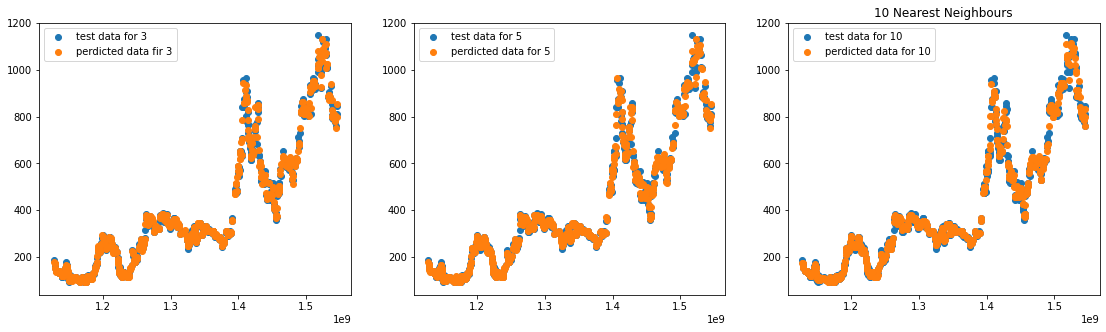

In [142]:
# KNN 3 , 5 , 10
from sklearn.neighbors import KNeighborsRegressor

fig, ax = plt.subplots(nrows=1, ncols=3) # number of subplots
fig.set_figwidth(19) # figure width in cm
fig.set_figheight(5) # figure height in cm

neigh = KNeighborsRegressor(n_neighbors=3)
neigh.fit(X_train, y_train)
y_pre = neigh.predict(X_test)

mse = sklearn.metrics.mean_squared_error(y_pre, y_test)

rmse = math.sqrt(mse)
print("the RMSE for KNN 3 is :" , rmse)

ax[0].scatter( X_test , y_test , label='test data for 3' )
ax[0].scatter(X_test , y_pre  ,  label='perdicted data fir 3')
ax[0].legend()
#########################knn5
neigh = KNeighborsRegressor(n_neighbors=5)
neigh.fit(X_train, y_train)
y_pre = neigh.predict(X_test)

mse = sklearn.metrics.mean_squared_error(y_pre, y_test)

rmse = math.sqrt(mse)
print("the RMSE for KNN 5 is :" , rmse)

ax[1].scatter( X_test , y_test , label='test data for 5' )
ax[1].scatter(X_test , y_pre  ,  label='perdicted data for 5')
ax[1].legend()
#########################knn5
neigh = KNeighborsRegressor(n_neighbors=10)
neigh.fit(X_train, y_train)
y_pre = neigh.predict(X_test)

mse = sklearn.metrics.mean_squared_error(y_pre, y_test)

rmse = math.sqrt(mse)
print("the RMSE for KNN 10 is :" , rmse)

ax[2].scatter( X_test , y_test , label='test data for 10' )
ax[2].scatter(X_test , y_pre  ,  label='perdicted data for 10')
ax[2].legend()



As you can wee the KNN method worked better than the Regression method, and for N = 5 the RMSE is better than the others! and from the plots we can see that the data has been perdeicted good.

In [143]:
# ARIMA : 
from matplotlib import pyplot as plt
from pmdarima.arima import auto_arima
import warnings
import itertools
from statsmodels.tsa.arima_model import ARIMA
import pandas as pd
import numpy as np
def arimamodel(timeseries):
    automodel = auto_arima(timeseries,start_p=1,start_q=1,test="adf",seasonal=False,trace=True)
    return automodel

d = pd.read_csv('Project_Intro2ML_dataset.csv')
data = d.iloc[:3299]

Close = data['Close']
y = Close

idxtest = []
len = data.shape[0]

for i in range(len):
    if i > len*0.8:
        idxtest .append(False)
    else:
        idxtest .append(True)

idxtest  = np.array(idxtest)
TestData = data[~idxtest ]
TrainData = data[idxtest ]

y_train = TrainData['Close']
y_test = TestData['Close']
    
automodel = arimamodel(y_train)
forecast = automodel.predict(n_periods=(y_test.shape[0]))
forecast = pd.DataFrame(forecast,index = y_test.index,columns=['Prediction'])

plt.plot(y_test, label='actual')
plt.plot(forecast, label='predicted for arima model')
plt.legend()

import math 
from sklearn.metrics import mean_squared_error

rmse = math.sqrt(mean_squared_error(y_test,forecast))
print("the rmse error for arima is :" , rmse)


In [ ]:
# on of the non staitionary codes :
'''
idxtest = []
len = data.shape[0]

for i in range(len):
    if i > len*0.8:
        idxtest .append(False)
    else:
        idxtest .append(True)

idxtest  = np.array(idxtest)
TestData = data[~idxtest ]
TrainData = data[idxtest ]


y_train = TrainData['Close']
y_test = TestData['Close']

#

from pmdarima.arima import auto_arima
model = auto_arima(y_train, error_action='ignore', suppress_warnings=True,trace=True)
model.fit(y_train) 
forecast = model.predict(n_periods=len(y_test).shape[0])

model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(y_train)

forecast = model.predict(n_periods=len(y_test))
forecast = pd.DataFrame(forecast,index = y_test.index,columns=['Prediction'])

#plot the predictions for validation set
plt.plot(y_train, label='Train')
plt.plot(y_test, label='Valid')
plt.plot(forecast, label='Prediction')
plt.show()

#calculate rmse
from math import sqrt
from sklearn.metrics import mean_squared_error

rms = sqrt(mean_squared_error(y_test,forecast))
print(rms)
'''

the rmse for prophet is 78.25243034657149


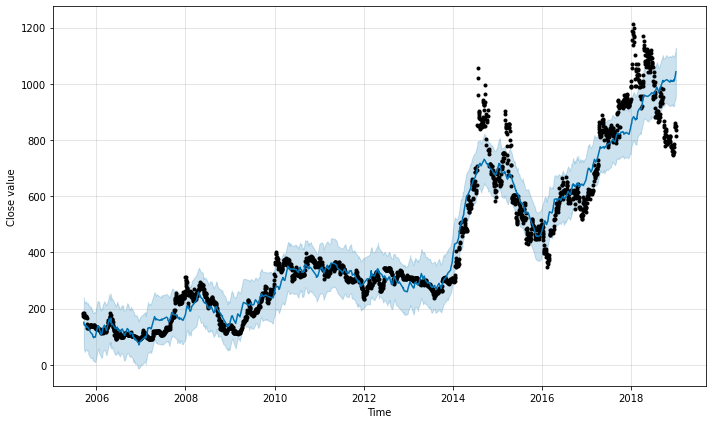

In [189]:
# prophet
from fbprophet import Prophet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
# making the data usable for prophet functions!
d = pd.read_csv('Project_Intro2ML_dataset.csv')
data = d.iloc[:3299]
data_prop = data.rename(columns={'Date': 'ds'})
data_prop = data_prop.rename(columns={'Close': 'y'})


data_prop.head()
data_prop.drop(columns=['Open', 'High' , 'Low' , 'Last' , 'Total Trade Quantity' , 'Turnover (Lacs)'])

del data_prop['Open']
del data_prop['High']
del data_prop['Low']
del data_prop['Last']
del data_prop['Total Trade Quantity']
del data_prop['Turnover (Lacs)']
data = data_prop

y_train, y_test = train_test_split(data_prop, test_size=0.2, random_state=0)
m = Prophet(daily_seasonality=True)
m.fit(y_train)
#data_prop.head()
#data_prop.set_index('ds').y.plot().figure

future_data = m.make_future_dataframe(periods=12, freq='M')
forecastm = m.predict(y_test)
m.plot(forecastm,xlabel='Time', ylabel='Close value')
forecast = m.predict(future_data)
forecast = forecast[:659]

realval = data['y'][math.floor(0.8*data.shape[0])+1:]
predictval = forecast['yhat']



leny = predictval.shape[0]
Valid = []
predicted = []
for i in range(1 , realval.__len__()):
   Valid.append(realval.iloc[i])   
   predicted.append(predictval.iloc[i])

#forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
#se = np.square(forecast.loc[:, 'yhat'] - data)
#mse = np.mean(se)
#rmse = np.sqrt(mse)

rmse = sqrt(mean_squared_error(predicted, Valid))
print("the rmse for prophet is" , rmse)


As you can wee the prophet model couln'd predict the value accuratly and that is because the big dicreartion in the value is suddent and can't be predicted just by the train values, and we need more data to be able to predict it!

In [ ]:
# Andicators:
#SMA
import pandas as pd
import numpy as np
n = 30
data = pd.read_csv('Project_Intro2ML_dataset.csv')
Close = data['Close']
data = df.iloc[:3299]
len = data.shape[0]

sma = []

for i in range(n):
    sma.append(0)
for i in range(n,len):
    sma.append(np.mean(Close.iloc[i - n : i - 1]))

sma.__len__()

3299

In [ ]:
#EMA
wm = 2/(n + 1)
ema = np.zeros((len, 1))
for i in range(1, len):
  ema[i] = ema[i-1] - wm*ema[i-1] + wm*Close[i]

ema = ema.tolist()
          
ema.__len__()

3299

In [ ]:
# Momentum
Momen = []
for i in range(n):
  Momen.append(Close[i])
for i in range(n , len):
  Momen.append(Close[i] - Close[i - n])

Momen.__len__()

3299

In [ ]:
#ROC

ROC = []
for i in range(n):
     ROC.append(0)
for i in range(n, len):
  ROC.append((Close[i]- Close[i - n])/Close[i - n])

ROC.__len__()

3299

In [ ]:
#Stoch K

Stoch = []
for i in range(len):
    High = 0
    Low = 30000
    if i  < n:
      for j in range (i):
        if (data['High'][j]) > High:
          High = data['High'][j]
        if (data['Low'][j]) <  Low:
          Low = data['Low'][j]  
    if i >= n:
      for j in range(i - n, i):
        if (data['High'][j]) > High:
          High = data['High'][j]
        if (data['Low'][j]) <  Low:
          Low = data['Low'][j]  
    Stoch.append((Close[i] - High)*100/(High - Low))

Stoch.__len__()

3299

In [ ]:
#Stoch D

StochD = []
StochD.append(Stoch[0]/3)
StochD.append((Stoch[0] + Stoch[1])/3)
for i in range(2,len):
  StochD.append((Stoch[i] + Stoch[i-1] + Stoch[i-2])/3)

StochD.__len__()

3299

In [ ]:
# Stoch Fast D

StochFastD = []
StochFastD.append(StochD[0]/3)
StochFastD.append( (StochD[0] + StochD[1])/3 )
for i in range(2,len):
  StochFastD.append((StochD[i] + StochD[ i-1 ] + StochD[ i-2 ])/3)

StochFastD.__len__()

3299

In [ ]:
# Williams R

willr = []        
for i in range(len):
    High = 0
    Low = 30000
    if i  < n:
      for j in range (i):
        if (data['High'][j]) > High:
          High = data['High'][j]
        if (data['Low'][j]) <  Low:
          Low = data['Low'][j]  
    if i >= n:
      for j in range(i - n, i):
        if (data['High'][j]) > High:
          High = data['High'][j]
        if (data['Low'][j]) <  Low:
          Low = data['Low'][j]   
    willr.append( (High  - Close[i])/(High - Low))
willr.__len__()

3299

In [ ]:
# BOP          
bop = []
for i in range(len):
  bop.append((Close[i] - data['Open'][i])/(data['High'][i] - data['Low'][i]))
bop.__len__()

3299

In [ ]:
# AD line 
adl = []
for i in range(len):
  adl.append(((Close[i] - data['Low'][i])-(data['High'][i] - Close[i]))/(data['High'][i] - data['Low'][i])  )

adl.__len__()

3299

In [ ]:
# OSCP
oscp = []
for i in range (2*n):
  oscp.append(0)
for i in range (len-2*n):
  oscp.append( (np.mean(data['Close'].iloc[i - n : i - 2*n])  -  np.mean(data['Close'].iloc[i : i - 2*n]))/ np.mean(data['Close'].iloc[i - n : i - 2*n]))

oscp.__len__()

3299

In [ ]:
#Disparity
disp = []
for i in range(9):
  disp.append(0)
for i in range (len-9):
  disp.append( data['Close'][i] / np.mean(data['Close'].iloc[i: i-9 ]) )

disp.__len__()


3299

In [ ]:
# making the data frame with some of these andicators! 
d = pd.read_csv('Project_Intro2ML_dataset.csv')
data = d.iloc[:3299]

dataframe = {'SMA' : sma,
        'Willams R' : willr,
        'ROC': ROC, 
        'ADL': adl, 
        'StochFastD': StochFastD,
        'StochD' : StochD,
        'Stoch':Stoch,
        'BOP' : bop,
        'Momentum' : Momen} 
 
df = pd.DataFrame(dataframe)

#data['SMA'] = df['SMA'] 
#data['EMA'] = df['EMA']
#data['Disparity'] = df['Disparity']
#data['OSCP'] = df['OSCP']
data['Willams R'] = df['Willams R']
data['ROC'] = df['ROC']
data['ADL'] = df['ADL']
data['Stoch'] = df['Stoch']
data['StochD'] = df['StochD']
data['StochFastD'] = df['StochFastD']
data['BOP'] = df['BOP']
data['Momentum'] = df['Momentum']

df['Open'] = data['Open']
df['High'] = data['High']
df['Low'] = data['Low']
df['Last'] = data['Last']
df['Total Trade Quantity'] = data['Total Trade Quantity']
df['Turnover (Lacs)'] = data['Turnover (Lacs)']



In [161]:
print(df)

             SMA  Willams R       ROC  ...      Stoch       BOP  Momentum
0       0.000000   0.027125  0.000000  ...  -2.712500 -0.465517    813.75
1       0.000000   0.335249  0.000000  ... -33.524904 -0.470833    825.90
2       0.000000   0.150972  0.000000  ... -15.097160 -0.213873    836.95
3       0.000000   0.267218  0.000000  ... -26.721763 -0.529536    848.45
4       0.000000   0.097337  0.000000  ...  -9.733701 -0.302920    857.70
...          ...        ...       ...  ...        ...       ...       ...
3294  155.860345   0.019147  0.330216  ...  -1.914708 -0.102941     45.90
3295  157.029310   0.084530  0.341147  ...  -8.452951 -0.008333     47.30
3296  158.624138   0.134769  0.344612  ... -13.476874  0.086957     46.85
3297  160.348276   0.191388  0.349266  ... -19.138756  0.644928     46.40
3298  162.070690   0.285486  0.269498  ... -28.548644  0.080808     36.80

[3299 rows x 9 columns]


In [167]:
#making the data and the labels ready using indexes
# loading the data :
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import math

d = pd.read_csv('Project_Intro2ML_dataset.csv')
data = d.iloc[:3299]
y = data['Close']

##################### making test and train sets as lists:
lenx  = data.shape[0]
lentrain = math.floor(lenx*0.8)
lentest = lenx - lentrain
TrainIdx = []
TestIdx = []
for i in range(lenx):
    if i <= lenx*0.8:
        TrainIdx.append(True)
        TestIdx.append(False)
    else:
        TrainIdx.append(False)
        TestIdx.append(True)

TrainIdx = np.array(TrainIdx)
TestIdx = np.array(TestIdx)


##new try!!!
TrainData = data[TrainIdx]
TestData = data[~TrainIdx]

y_train =TrainData['Close']
y_test = TestData['Close']



X_train = data[TrainIdx]
X_test = data[~TrainIdx]

#y_test = y[TestIdx]
#y_train = y[TrainIdx]

X_train = df[TrainIdx]
X_test = df[TestIdx]

X_train = np.array(X_train)
X_test = np.array(X_test)


########################### making the labels
trainlabel = []
testlabel = []
trainlabel.append(0)
for i in range(1, y_train.shape[0]):
    if y_train.iloc[i] <= y_train.iloc[ i - 1] :
        trainlabel.append(0)
    else:
        trainlabel.append(1)
if y_test.iloc[0] <= y_train.iloc[y_train.shape[0] - 2]:
    testlabel.append(0)
else:
    testlabel.append(1)

for i in range(1, y_test.shape[0]):
    if y_test.iloc[i] <= y_test.iloc[i - 1]:
        testlabel.append(0)
    else:
        testlabel.append(1)        
        
trainlabel = np.array(trainlabel)  
testlabel = np.array(testlabel)




In [172]:
#SVM
from sklearn import svm
clf = svm.SVC()
clf = svm.SVR().fit(X_train,trainlabel)
y_presvm = clf.predict(X_test)

from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(testlabel, y_presvm))
print("the rmse for svm is : " , rmse)

sum = 0
for i in range(y_pre.__len__()-1):
    sum = sum + abs(testlabel - y_presvm[i])
accuracy =1- sum/y_pre.__len__()
accuracy = np.mean(accuracy)
print("the accuracy for svm is :" , accuracy)
'''
plt.plot( y_test , label='actual' )
plt.plot(y_presvm  ,  label='predicted')
plt.legend()
'''

the rmse for svm is :  0.6527309481259987
the accuracy for svm is : 0.4844120280199397


"\nplt.plot( y_test , label='actual' )\nplt.plot(y_presvm  ,  label='predicted')\nplt.legend()\n"

In [174]:
#KNN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, trainlabel)
y_preknn = knn.predict(X_test)
rmse = math.sqrt(mean_squared_error(testlabel, y_preknn ))

print('the rmse for knn 5 is: ' , rmse)

sum = 0
for i in range(y_pre.__len__()-1):
    sum = sum + abs(testlabel - y_preknn[i])
accuracy =1- sum/y_pre.__len__()
accuracy = np.mean(accuracy)
print("the accuracy for knn5 is :" , accuracy)

the rmse for knn 5 is:  0.6803105601635964
the accuracy for knn5 is : 0.503644180806548


In [176]:
# Classification Tree
from sklearn import tree
tree = tree.DecisionTreeClassifier()
tree = tree.fit(X_train, trainlabel)

y_pretree = tree.predict(X_test)
rmse = math.sqrt(mean_squared_error(testlabel,y_pretree))

print('the rmse for desition tree in ' , rmse)

sum = 0
for i in range(y_pre.__len__()-1):
    sum = sum + abs(testlabel - y_pretree[i])
accuracy =1- sum/y_pre.__len__()
accuracy = np.mean(accuracy)
print("the accuracy for tree is :" , accuracy)


the rmse for desition tree in  0.5255245230045986
the accuracy for tree is : 0.5025888628316549


In [180]:
# voting between the above
vote = []
for i in range(y_pre.__len__()-1):
    if( (y_pretree[i] + y_presvm[i] + y_preknn[i])/3 >= 1):
        vote.append(1)
    else:
        vote.append(0)

rmse = math.sqrt(mean_squared_error(y_test, vote))

sum = 0
y_testt = y_test.tolist()
for i in range(y_pre.__len__()-1):
    sum = sum + abs(testlabel - vote[i])
    
accuracy =1- sum/y_pre.__len__()
accuracy = np.mean(accuracy)
print("the accuracy for voting is :" , accuracy)


the accuracy for voting is : 0.5212121212121212


In [182]:
# making the PCA for 6 components
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
pca.fit(X_train)

X_trainpca = pca.transform(X_train)
X_testpca = pca.transform(X_test)

In [184]:
#SVM after PCA
from sklearn import svm
clf = svm.SVC()
clf = svm.SVR().fit(X_trainpca,trainlabel)
y_presvm = clf.predict(X_testpca)

from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(testlabel, y_presvm))
print("the rmse for svm after PCA is : " , rmse)

sum = 0
for i in range(y_pre.__len__()-1):
    sum = sum + abs(testlabel - y_presvm[i])
accuracy =1- sum/y_pre.__len__()
accuracy = np.mean(accuracy)
print("the accuracy for svm after PCA is :" , accuracy)

the rmse for svm after PCA is :  0.6528562404266408
the accuracy for svm after PCA is : 0.4844051673940344


In [185]:
#KNN after PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_trainpca, trainlabel)
y_preknn = knn.predict(X_testpca)
rmse = math.sqrt(mean_squared_error(testlabel, y_preknn ))

print('the rmse for knn 5 after PCA is: ' , rmse)

sum = 0
for i in range(y_pre.__len__()-1):
    sum = sum + abs(testlabel - y_preknn[i])
accuracy =1- sum/y_pre.__len__()
accuracy = np.mean(accuracy)
print("the accuracy for knn5 after PCA is :" , accuracy)

the rmse for knn 5 after PCA is:  0.6803105601635964
the accuracy for knn5 after PCA is : 0.503644180806548


In [186]:
# Classification Tree after PCA
from sklearn import tree
tree = tree.DecisionTreeClassifier()
tree = tree.fit(X_trainpca, trainlabel)

y_pretree = tree.predict(X_testpca)
rmse = math.sqrt(mean_squared_error(testlabel,y_pretree))

print('the rmse for desition tree after PCA in ' , rmse)

sum = 0
for i in range(y_pre.__len__()-1):
    sum = sum + abs(testlabel - y_pretree[i])
accuracy =1- sum/y_pre.__len__()
accuracy = np.mean(accuracy)
print("the accuracy for tree after PCA is :" , accuracy)


the rmse for desition tree after PCA in  0.6701980320207087
the accuracy for tree after PCA is : 0.4981192808203432


In [188]:
# voting after PCA
vote = []
for i in range(y_pre.__len__()-1):
    if( (y_pretree[i] + y_presvm[i] + y_preknn[i])/3 >= 1):
        vote.append(1)
    else:
        vote.append(0)

rmse = math.sqrt(mean_squared_error(y_test, vote))

sum = 0
y_testt = y_test.tolist()
for i in range(y_pre.__len__()-1):
    sum = sum + abs(testlabel - vote[i])
    
accuracy =1- sum/y_pre.__len__()
accuracy = np.mean(accuracy)
print("the accuracy for voting after PCA is :" , accuracy)


the accuracy for voting after PCA is : 0.5212121212121212
